# How population density affects the spread of Covid-19
Jason Kitamirike T00228531

In [37]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/9c/b9/5cead4f63b6d31bdefeb21a679bc5a7f4aaf262ca7e07e2bc1c341b68470/pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (89 kB)
Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/68/ae/23908e2bd441a67aaa6e0d4b7e5dabf621766a2438ca8455669a57aefb99/matplotlib-3.9.3-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Using cached matplotlib-3.9.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
Using cached matplotlib-3.9.3-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for seabor

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


## Data Cleaning

### Selecting Population Data

In [41]:
population_columns = ['NAME', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022', 'POPESTIMATE2023']

population_df = pd.read_csv('us-population-estimates.csv', usecols=population_columns)

### Selecting Land Area Data

In [42]:
land_area_columns = ['state', 'total_area_km2', 'land_area_km2']

land_area_df = pd.read_csv('us-state-land-area.csv', usecols=land_area_columns)

### Selecting Covid Data

Read in the CSV files containing daily COVID-19 reports, extracts the Province_State and Confirmed columns, adds a formatted date column derived from the filenames, and combines all the processed data into a single DataFrame. There is already a date column in the files but there might be some missing date values, that's why I used the file name

In [43]:
file_paths = glob.glob("./us-covid-19-daily-reports/*.csv")

covid_cases_columns = ['Province_State', 'Confirmed']

dataframes = []
for file in file_paths:
    date = os.path.basename(file).replace(".csv", "")
    formatted_date = pd.to_datetime(date, format="%m-%d-%Y").strftime("%m-%d-%Y")

    df = pd.read_csv(file, usecols=covid_cases_columns)
    df['Date'] = formatted_date
    dataframes.append(df)

covid_cases_df = pd.concat(dataframes)

# Data Preprocessing

### Rename the columns of the data frames

I renamed the columns to make them follow a standard and renamed 'NAME' and 'Province_State' to 'state' so the joins would be easier.

In [45]:
population_df.rename(columns={
    'NAME': 'state',
    'POPESTIMATE2020': 'population_estimate_2020',
    'POPESTIMATE2021': 'population_estimate_2021',
    'POPESTIMATE2022': 'population_estimate_2022',
    'POPESTIMATE2023': 'population_estimate_2023',
}, inplace=True)

covid_cases_df.rename(columns={
    'Province_State': 'state',
    'Confirmed': 'confirmed',
    'Date': 'date',
}, inplace=True)

### Filter out none U.S. States
The dataframes have us states and territories. In some they include Puerto Rico and U.S. Virgin Islands, but they don't all have the same territories, so I generated a list of the 50 states and filtered out the territories.

In [46]:
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
    'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
    'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

population_df = population_df[population_df['state'].isin(us_states)]
covid_cases_df = covid_cases_df[covid_cases_df['state'].isin(us_states)]
land_area_df = land_area_df[land_area_df['state'].isin(us_states)]

# Data Transformation

### Calculate the Population Density
I had first calculated the density using total area but changed it to land area because it removes the area taken up by water.

In [47]:
# Merge population and land area frames on the state column
merged_df = population_df.merge(land_area_df, left_on='state', right_on='state')

merged_df['density_2020'] = merged_df['population_estimate_2020'] / merged_df['land_area_km2']
merged_df['density_2021'] = merged_df['population_estimate_2021'] / merged_df['land_area_km2']
merged_df['density_2022'] = merged_df['population_estimate_2022'] / merged_df['land_area_km2']
merged_df['density_2023'] = merged_df['population_estimate_2023'] / merged_df['land_area_km2']

population_density_df = merged_df[['state', 'density_2020', 'density_2021', 'density_2022', 'density_2023']]

# Data Selection
Group the Data by Years

### 2020 Data

In [48]:
covid_cases_2020_df = covid_cases_df[
    pd.to_datetime(covid_cases_df['date'], format="%m-%d-%Y").dt.year == 2020
].groupby('state').sum()

data_2020 = covid_cases_2020_df[['confirmed']].merge(population_density_df[['state','density_2020']], on='state')

### 2021 Data

In [49]:
covid_cases_2021_df = covid_cases_df[
    pd.to_datetime(covid_cases_df['date'], format="%m-%d-%Y").dt.year == 2021
].groupby('state').sum()

data_2021 = covid_cases_2021_df[['confirmed']].merge(population_density_df[['state','density_2021']], on='state')

### 2022 Data

In [50]:
covid_cases_2022_df = covid_cases_df[
    pd.to_datetime(covid_cases_df['date'], format="%m-%d-%Y").dt.year == 2022
].groupby('state').sum()

data_2022 = covid_cases_2022_df[['confirmed']].merge(population_density_df[['state','density_2022']], on='state')

### 2023 Data

In [51]:
covid_cases_2023_df = covid_cases_df[
    pd.to_datetime(covid_cases_df['date'], format="%m-%d-%Y").dt.year == 2023
].groupby('state').sum()

data_2023 = covid_cases_2023_df[['confirmed']].merge(population_density_df[['state','density_2023']], on='state')

# Data Mining

### Correlation
There was no correlation found in any of the years to suggest that there was a relationship between the population density and covid cases

              density_2020  confirmed
density_2020      1.000000   0.195556
confirmed         0.195556   1.000000


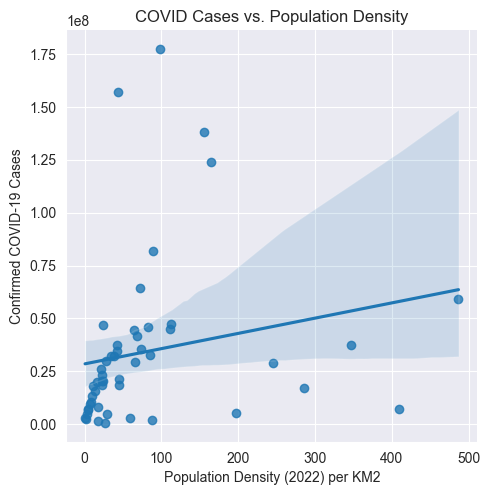

In [52]:
sns.lmplot(x="density_2020", y="confirmed", data=data_2020)
plt.xlabel('Population Density (2022) per KM2')
plt.ylabel('Confirmed COVID-19 Cases')
plt.title('COVID Cases vs. Population Density')
print(data_2020[['density_2020', 'confirmed']].corr())


              density_2021  confirmed
density_2021      1.000000   0.153027
confirmed         0.153027   1.000000


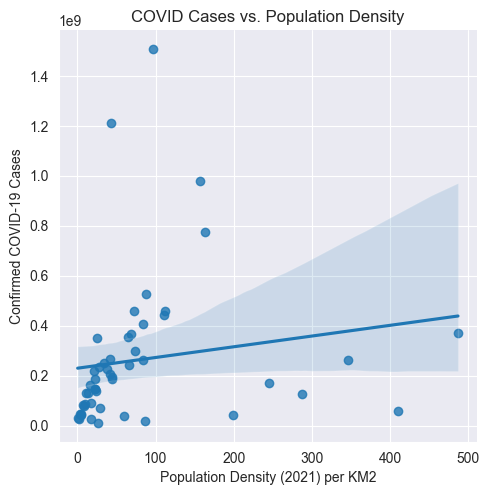

In [53]:
sns.lmplot(x="density_2021", y="confirmed", data=data_2021)
plt.xlabel('Population Density (2021) per KM2')
plt.ylabel('Confirmed COVID-19 Cases')
plt.title('COVID Cases vs. Population Density')
print(data_2021[['density_2021', 'confirmed']].corr())

              density_2022  confirmed
density_2022      1.000000   0.171175
confirmed         0.171175   1.000000


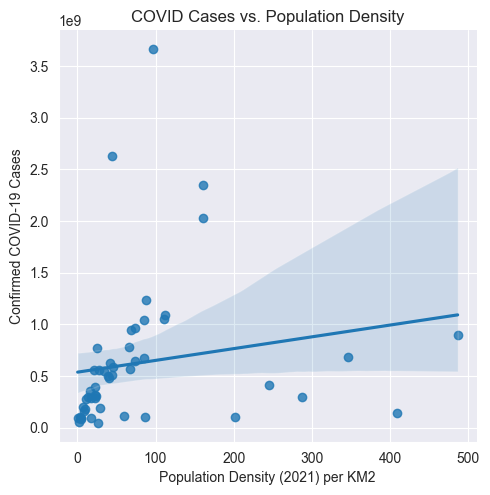

In [54]:
sns.lmplot(x="density_2022", y="confirmed", data=data_2022)
plt.xlabel('Population Density (2021) per KM2')
plt.ylabel('Confirmed COVID-19 Cases')
plt.title('COVID Cases vs. Population Density')
print(data_2022[['density_2022', 'confirmed']].corr())

              density_2023  confirmed
density_2023      1.000000   0.177018
confirmed         0.177018   1.000000


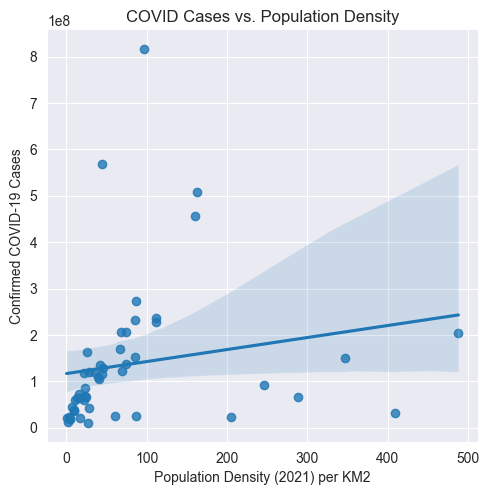

In [55]:
sns.lmplot(x="density_2023", y="confirmed", data=data_2023)
plt.xlabel('Population Density (2021) per KM2')
plt.ylabel('Confirmed COVID-19 Cases')
plt.title('COVID Cases vs. Population Density')
print(data_2023[['density_2023', 'confirmed']].corr())

### Linear Regression
Running a Linear Regression algorithm I failed to find a relationship between them.

Coefficient (slope): 69184.11733383016
Intercept: 30254023.239221476
R-squared: -0.1737187704277079


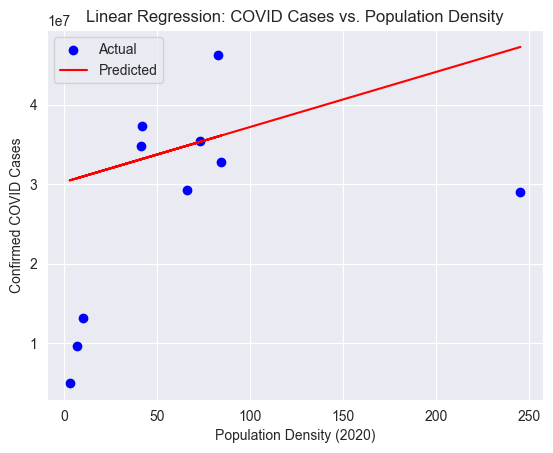

In [56]:
X = data_2020[['density_2020']]
y = data_2020['confirmed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Coefficient (slope): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

r2 = model.score(X_test, y_test)
print(f"R-squared: {r2}")

plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('Population Density (2020)')
plt.ylabel('Confirmed COVID Cases')
plt.title('Linear Regression: COVID Cases vs. Population Density')
plt.legend()
plt.show()


### Clustering

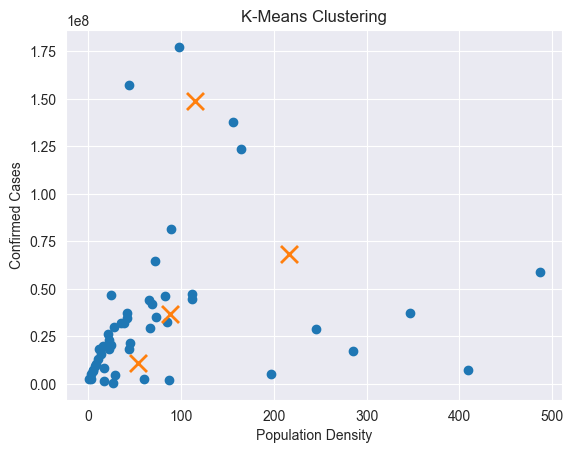

In [57]:
clustering_data = data_2020[['density_2020', 'confirmed']]

kmeans = KMeans(n_clusters=4, random_state=50)
kmeans.fit(clustering_data)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
data_2020['cluster'] = kmeans.fit_predict(clustering_data)

plt.scatter(data_2020['density_2020'], data_2020['confirmed'])
plt.scatter(centroids[:, 0],centroids[:, 1],marker='x', s=150, linewidths=2, zorder=10)
plt.xlabel('Population Density')
plt.ylabel('Confirmed Cases')
plt.title('K-Means Clustering')
plt.show()

### Time Series Analysis

As I was looking at the output of the correlation I realized that there was a jump in cases in 2022, so I added a Time Series Analysis just to check if I could visualize the cases over time


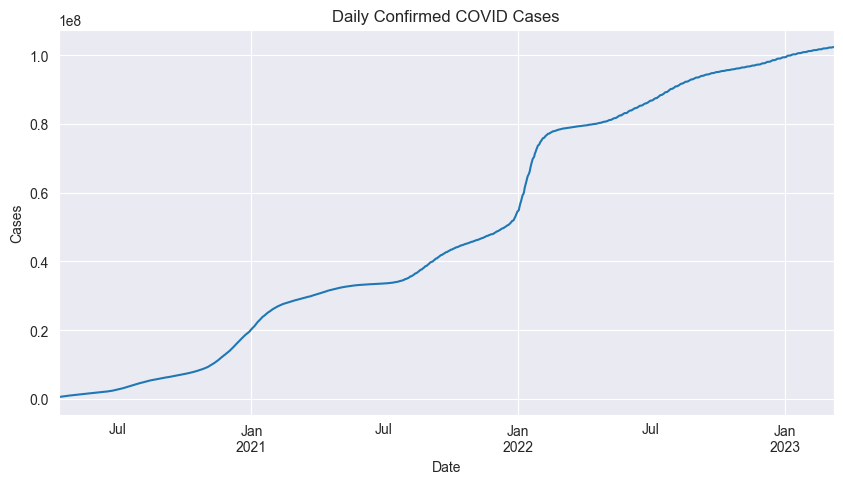

In [58]:
covid_cases_df['date'] = pd.to_datetime(covid_cases_df['date'], format='%m-%d-%Y')
daily_cases = covid_cases_df.groupby('date')['confirmed'].sum()

daily_cases.plot(figsize=(10, 5), title='Daily Confirmed COVID Cases', ylabel='Cases', xlabel='Date')
plt.show()


## Pattern Evaluation

### Objective
I set out to find if there was a relationship between population density and the spread of COVID-19 in the US. I found that there was no significant correlation observed between population density and the spread of COVID-19.

### Methods Applied

#### Correlation
I checked for correlation for all four years and the correlation matrix gave me low numbers for correlation less than 0.2 for all years. I was able to determine that there was no correlation

#### Linear Regression
After concluding there was no correlation I moved on to Linear Regression, but I only did it for 2020 to start with to check, but I did not find there to be Linear Regression.

#### Clustering
I attempted to group regions by population density and case spread. I don't think I executed the clustering properly

#### Time Series Analysis
Though not part of the original question, I was going over the output from the correlation, and it had seemed to me that there was a jump in cases in 2022. With the Time Series Analysis Graph I could see a spike in cases in 2022.

### Conclusions
Population density alone does not appear to be a reliable predictor of COVID-19 spread in the US.
Clustering might need more work to provide valuable information.

### Reflection
While researching I found out that there was a lot more that contributes to the spread of diseases than just populations. I was not expecting to be as interested as I found myself to be. I'm most proud of the for loop that reads in the covid cases and uses the file name and sets a Date column value. I would try to figure out clustering and apply it properly in my project. I would use some more algorithms, and lastly I would have spared more time to the project.